# OSMnx Intersection cleaning tuning

Exploring intersection simplification parameters for suburbs in Helsinki based on [code by Carl Higgs](https://github.com/carlhiggs/osmnx-intersection-tuning) (code developed for the Australian National Liveability Study 2018, in January 2019).
OSMnx functionality may have changed, hence requiring code updates.

Supports testing global liveability indices, Helsinki version that's under construction in here: https://github.com/VuokkoH/global-indicators/tree/helsinki


In [1]:
import os
import shapely
import geopandas as gpd
import osmnx as ox, matplotlib.pyplot as plt, numpy as np
import matplotlib.patches as patches
ox.settings.log_console=True
ox.settings.use_cache=True

%matplotlib inline

ox.__version__

'1.1.2'

In [2]:
# Organization-spesific proxy settings from a separate file not in git (!)
from my_proxy import http_proxy

os.environ['http_proxy'] = http_proxy
os.environ['https_proxy'] = http_proxy

## Pedestrian network definition

The liveability indicators calculation (by Liu, Higgs, Boeing et al.) uses a custom pedestrian definition on [lines 146-154 of _project_seup.py](https://github.com/VuokkoH/global-indicators/blob/helsinki/process/pre_process/_project_setup.py#L146)
that doesn't exclude cycling paths (under the assumption that either walking is allowed on them, or that it may act as a proxy for a nearby walkable path 

Note: this assumption may not hold for all settings, so perhaps we need to allow greater flexibility for some cities to customise this, including for other tags?

In [3]:

pedestrian = '["area"!~"yes"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["service"!~"private"]["access"!~"private"]'


In [4]:
def intersection_tuning(address, tolerance=[15,12,10,8,5], distance=750):
    # print(address)
    G = ox.graph_from_address(address, custom_filter= pedestrian, dist=distance)
    G_proj = ox.project_graph(G)
    g_proj_gdfs = ox.graph_to_gdfs(G_proj, nodes=False, edges=True, fill_edge_geometry=True)
    #itereate over cleaning buffer distance
    buffers = tolerance
    # instantiate plot
    fig, axarr = plt.subplots(ncols=5, sharex='col', sharey='row', squeeze=False, figsize=(18,4.5), dpi=80)
    for i in range(len(buffers)):
        
        # clean up the intersections and extract their xy coords
        ## Old approach:
        #intersections = ox.clean_intersections(G_proj, tolerance=buffers[i], dead_ends=False)
        
        intersections = ox.consolidate_intersections(G_proj, tolerance=buffers[i], rebuild_graph=False, dead_ends=False)
        points = np.array([point.xy for point in intersections])
        
        # plot the cleaned-up intersections
        g_proj_gdfs.plot(ax = axarr[0][i])
        axarr[0][i].scatter(x=points[:,0], y=points[:,1], s = 10, zorder=2, color=None, edgecolors='#000000')
        axarr[0][i].set_title("Tolerance: {}".format(buffers[i]))
        axarr[0][i].set_aspect(1)
        axarr[0][i].set_axis_off()
        
        # axarr[0][i].add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2))
    plt.suptitle(address, fontsize=14, fontweight='bold')    
    plt.tight_layout()
    plt.show()
  

New function for fetching the intersections as a GeoDataFrame.

In [5]:
def get_intersections(place, tolerance=5, distance=1000):
    
    if type(place) == str:
        print("Graph from address:", place)
        G = ox.graph_from_address(place, custom_filter=pedestrian, dist=distance)
        
    else: # should be a shapely polygon... can add a check for this..
        print("Graph from polygon")
        G = ox.graph_from_polygon(place, custom_filter=pedestrian)

    G_proj = ox.project_graph(G)
    g_proj_gdfs = ox.graph_to_gdfs(G_proj, nodes=False, edges=True, fill_edge_geometry=True)
    
    intersections = ox.consolidate_intersections(G_proj, 
                                                 tolerance=tolerance, 
                                                 rebuild_graph=False, 
                                                 dead_ends=False)
    
    return intersections

## Quick check across finnish cities

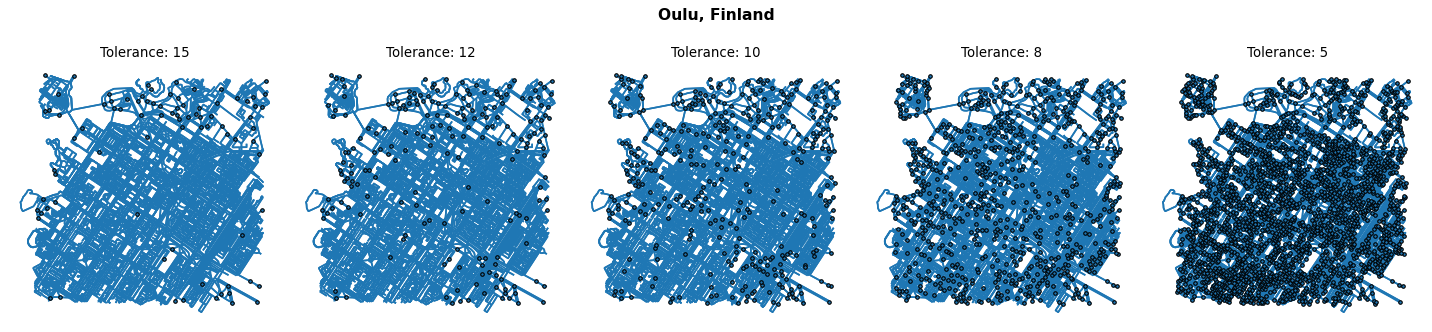

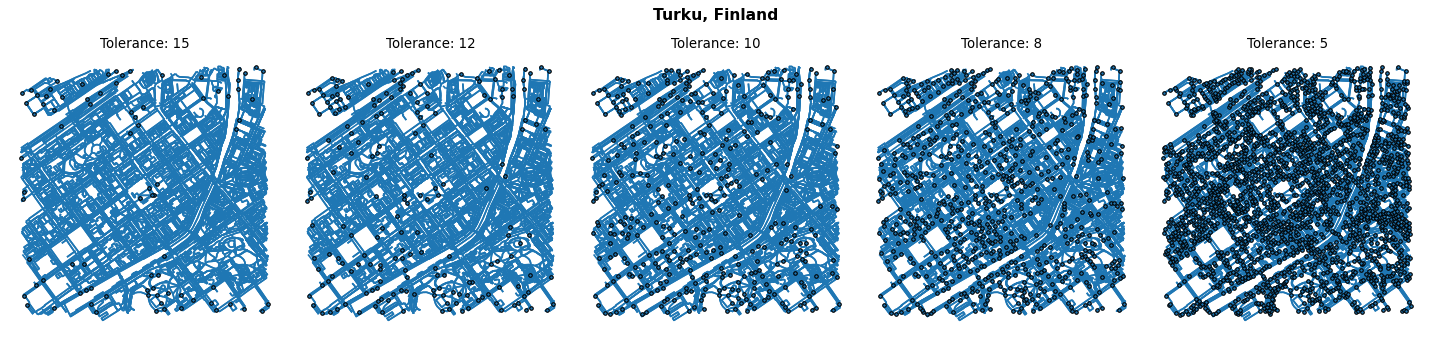

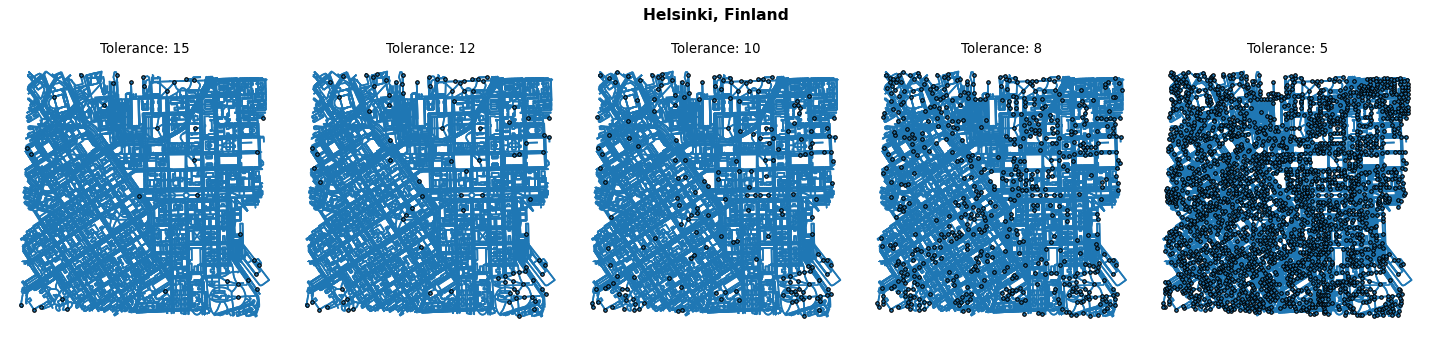

In [6]:
for address in ['Oulu, Finland',
                'Turku, Finland',
                'Helsinki, Finland',
               ]:
    intersection_tuning(address)

In [7]:
## Explore sub-regions and print intersections to file

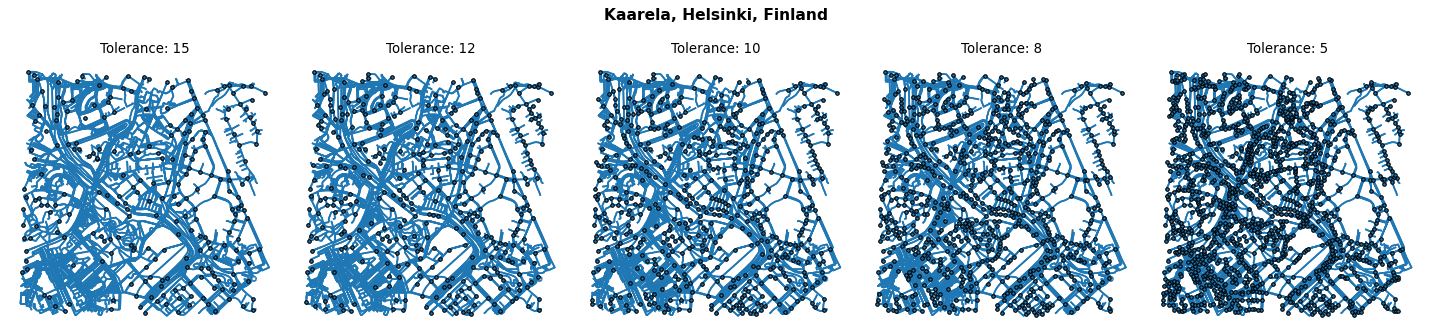

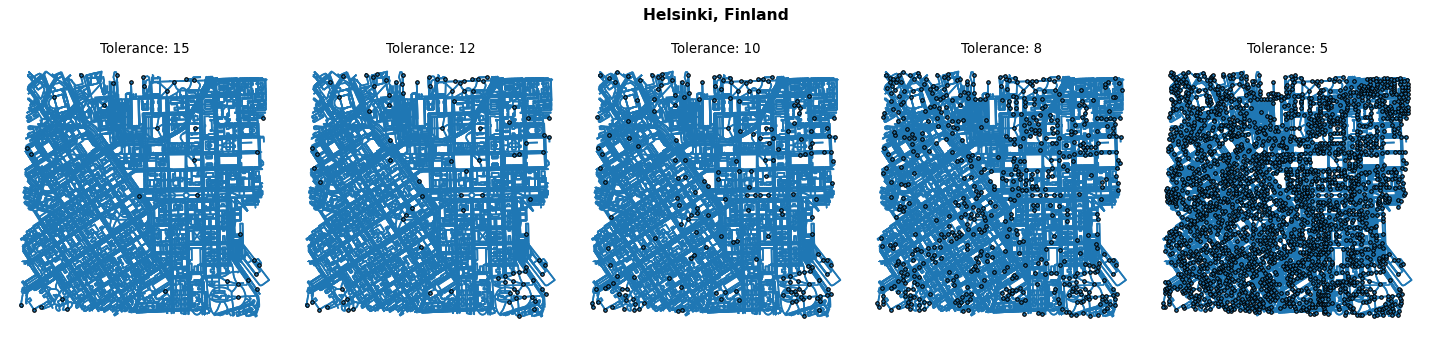

In [8]:
for address in ['Kaarela, Helsinki, Finland',
                'Helsinki, Finland',
               ]:
    intersection_tuning(address)

<AxesSubplot:>

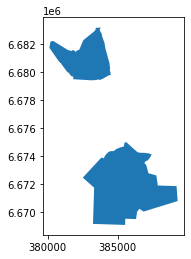

In [9]:
data = gpd.read_file("data/case_areas.gpkg")
data.plot()

In [10]:
# Add buffer to avoid edge-effects
data.geometry = data.buffer(1000)

In [11]:
# Project to WGS84 for OSM data fetching
data = data.to_crs(4326)

In [12]:
data.head()

Id                name                                           geometry
0   0             Kaarela  POLYGON ((24.83384 60.23982, 24.83322 60.24012...
1   0  HelsinkiCityCentre  POLYGON ((24.87921 60.16168, 24.87070 60.16521...

In [13]:
tol = 5

for name in data.name:
    intersections = get_intersections(data.loc[data["name"]==name, "geometry"].values[0], tolerance=tol)
    intersections.to_file(fr"data/OSM_intersections_tolerance_{tol}_{name}.gpkg")

Graph from polygon
Graph from polygon


## Further notes (by CH)

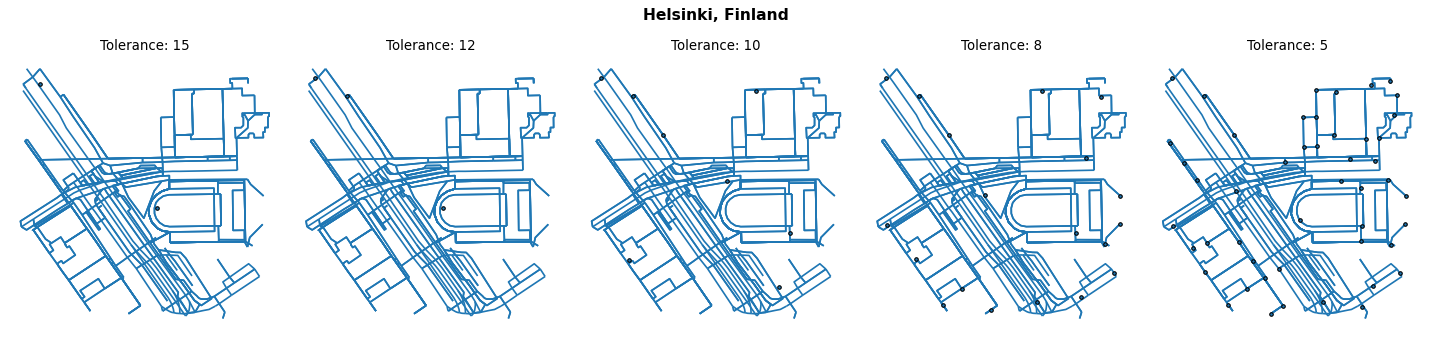

In [14]:
intersection_tuning('Helsinki, Finland',distance=100)

It is clear that the OSMnx consolidate intersections function is not adequately functioning with the identified network for Helsinki's CBD where many paths have been represented.  Some thought will be required how to account for this, because the result is clearly problematic: areas represented as having very dense pedestrian connectivity would result in an extreme under-estimation of true connectivity when calculation intersection density using the resulting data.  For this setting and using this network definition, a tolerance of 5m appears to work best.  The OSMnx default, for reference, is 10m.

I am not sure of the appropriate way forwards -- but while thinking about this is, it may help to consider maps of the above setting -- both using satellite imagery, and the OSM representation of connectivity:

https://www.google.com/maps/@60.167358,24.9448324,335m/data=!3m1!1e3
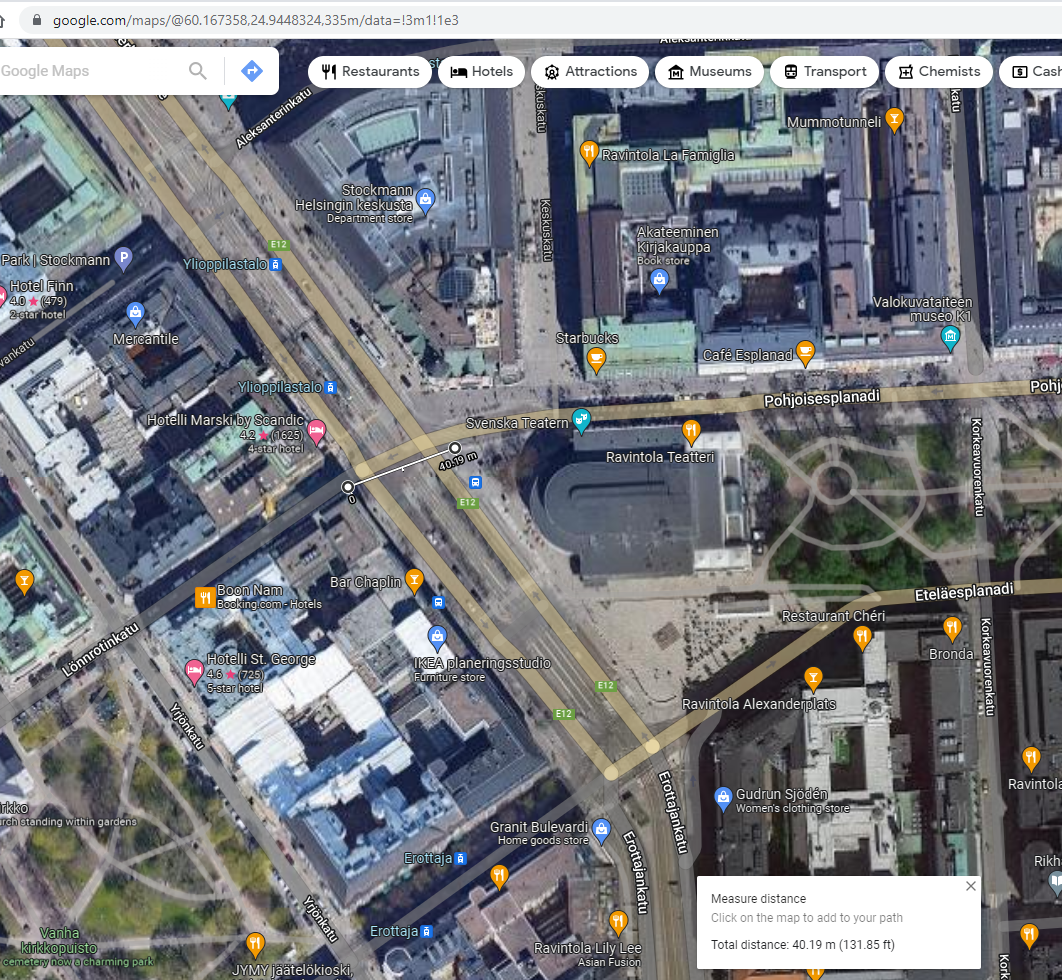

https://www.openstreetmap.org/query?lat=60.16706&lon=24.94281#map=17/60.16721/24.94318&layers=T
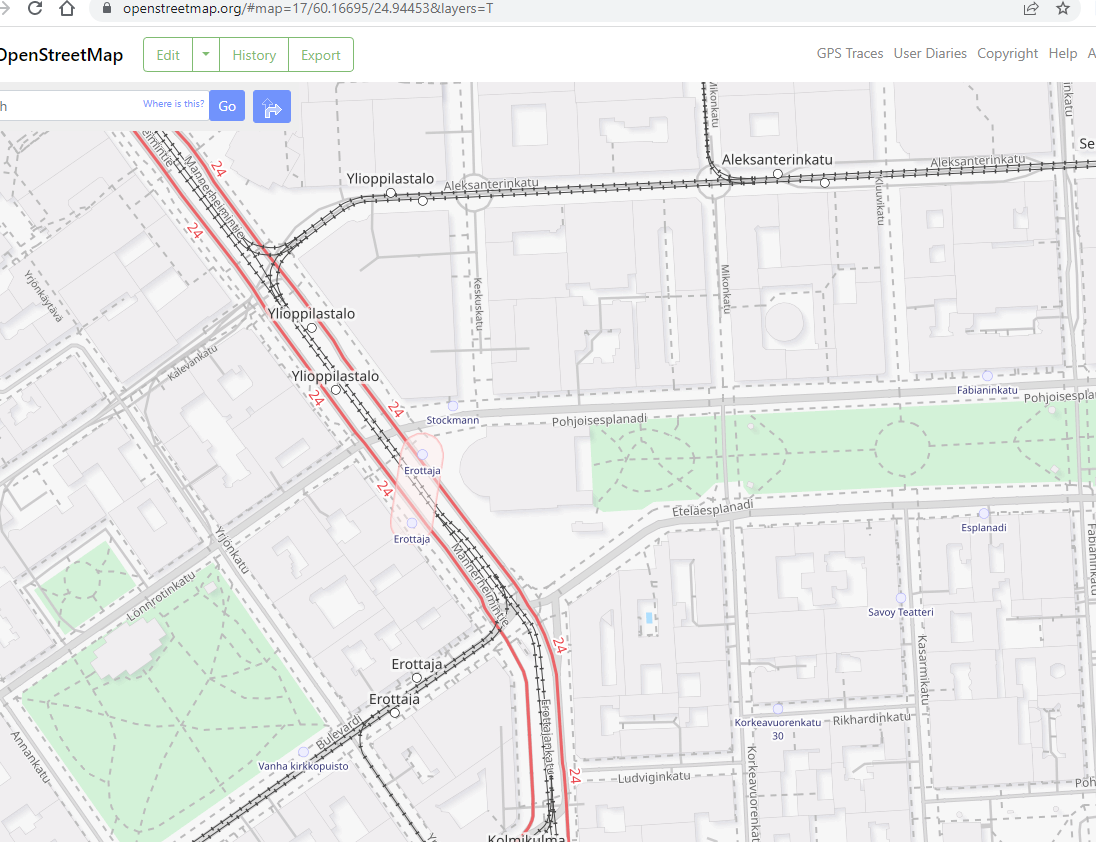


I don't believe the OSM image is displaying all the paths which are there ---for example, along Mannerheimintie which is about 40m wide, there appears to be 8 paths recorded, more or less every 5m.

It's actually quite a wide street (Google street view snippet below), and I suppose the paths are respective lanes of pedestrian/cyclist/vehicle traffice ---and because of the closeness of the paths recorded, it must trip up the consolidate intersections function.  For now, I'm not immediately sure how best to resolve this -- the consolidate intersections function works a bit differently to the older clean intersections function, although we have attempted to approximate its behaviour.  It will be worth doing a check to see how others are approaching this issue currently to decide how to move forwards.

https://www.google.com/maps/@60.1670092,24.9430692,3a,75y,346.19h,93.01t/data=!3m6!1e1!3m4!1sYKllPkctKKkJhQAjciPE6Q!2e0!7i13312!8i6656

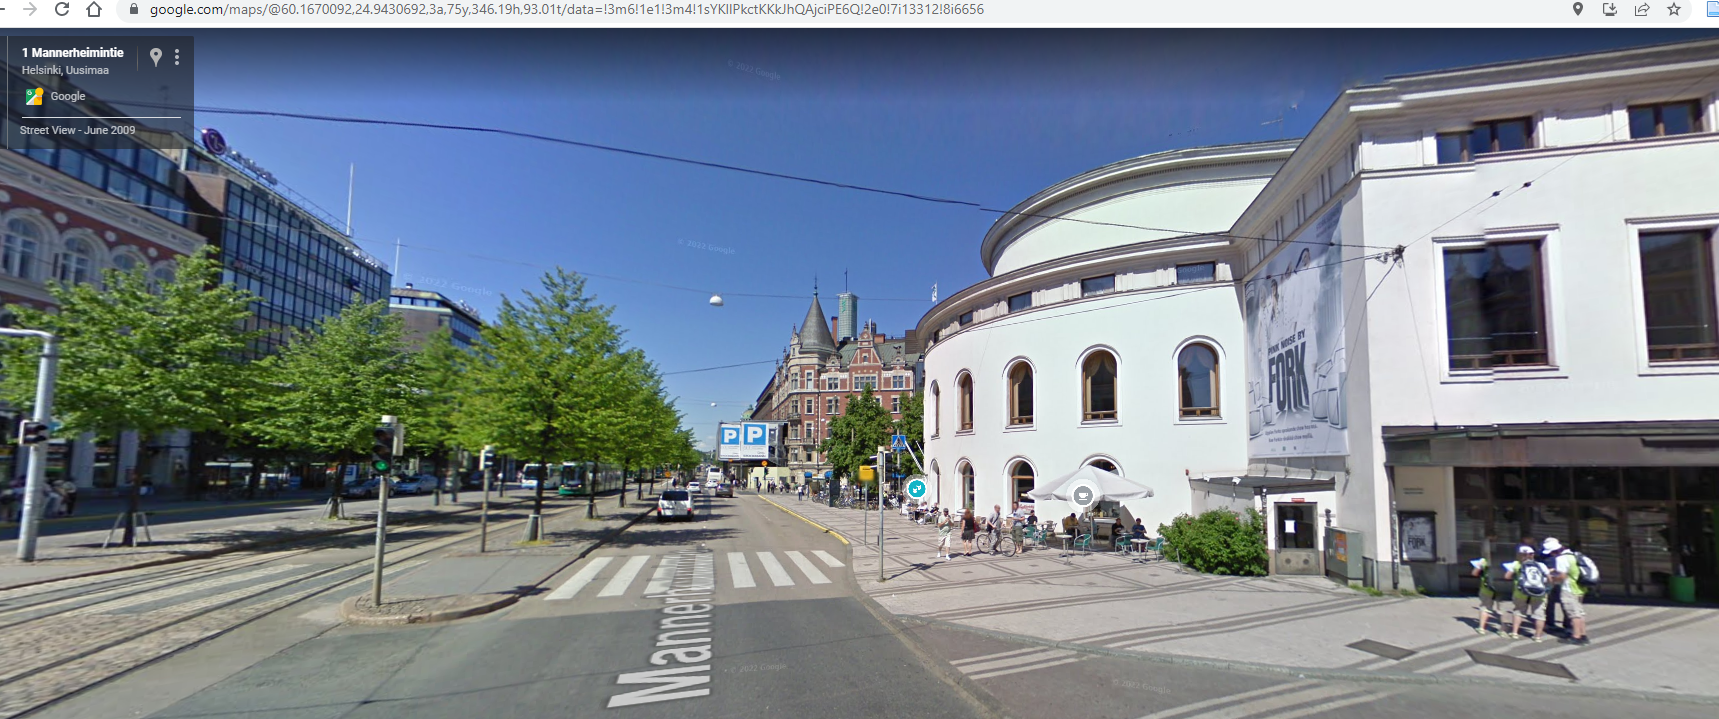